## Load in Packages

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(Matrix)
    library(stringr)
    library(ggalluvial)
    library(NMF)
    library(CellChat)
    library(patchwork)
    library(ComplexHeatmap)
    library(Cairo)
})

## Set Data Locations and Load in the Datasets

In [2]:
# set paths to data locations
io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2/"
# set the working directory
setwd(io$main)

## Load in Cell Type Colour Information

In [30]:
source("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/celltype_colours.r")

## CellChat Pipeline with Combined Datasets

In [4]:
## Step 1 ## Load in the Individual CellChat Objects

# set paths to data locations for the query samples
io$cellchat_wt = file.path(io$main, "projects/10_Axin_1_2/github_submission/outputs/7/cellchat_object_ss_wt.rds")
io$cellchat_mt = file.path(io$main, "projects/10_Axin_1_2/github_submission/outputs/7/cellchat_object_ss_mt.rds")

# load in the query data 
cellchat_wt <- readRDS(io$cellchat_wt)
cellchat_mt <- readRDS(io$cellchat_mt)

In [5]:
wt_celltypes <- unique(cellchat_wt@meta$ident)
mt_celltypes <- unique(cellchat_mt@meta$ident)

wt_mt_diff <- setdiff(wt_celltypes, mt_celltypes)
mt_wt_diff <- setdiff(mt_celltypes, wt_celltypes)

wt_mt_diff
mt_wt_diff

character(0)

[1] "Intermediate Mesoderm"             "Haematoendothelial progenitors #2"
[3] "Posterior Lateral Plate Mesoderm"  "Mesenchyme"

In [6]:
# -----------------------------------------------
# Lift CellChat object to harmonize cell labels
# -----------------------------------------------

# Use the cell group labels from the more complete dataset (e.g., mt)
# This ensures both CellChat objects share a common set of cell group labels
group.new <- levels(cellchat_mt@idents)

# Apply the label structure to the WT object
cellchat_wt <- liftCellChat(cellchat_wt, group.new)

# Note: We do not apply liftCellChat to cellchat_mt, since it already contains all relevant cell groups

# -----------------------------------------------
# Merge CellChat objects for comparative analysis
# -----------------------------------------------

# Combine the lifted WT and original MT CellChat objects
object.list <- list(wt = cellchat_wt, mt = cellchat_mt)

# Compute centrality scores for each dataset
object.list$wt <- netAnalysis_computeCentrality(object.list$wt, slot.name = "netP")
object.list$mt <- netAnalysis_computeCentrality(object.list$mt, slot.name = "netP")

# Merge the objects, appending dataset names as prefixes to cell names
cellchat <- mergeCellChat(object.list, add.names = names(object.list), cell.prefix = TRUE)

# Note:
# - Warnings about barcode renaming are expected.
# - CellChat will reassign colnames in the expression matrix to match metadata.
# - This step merges data slots: 'meta', 'idents', 'net', 'netP', 'DB', etc.

The CellChat object will be lifted up using the cell labels ExE Ectoderm, ExE Endoderm, Visceral Endoderm, Parietal Endoderm, Epiblast, Primitive Streak, Anterior Primitive Streak, Nascent mesoderm #1, Nascent mesoderm #2, Haematoendothelial progenitors #1, Haematoendothelial progenitors #2, Posterior Lateral Plate Mesoderm, Mesenchyme, Posterior Primitive Streak, Allantois Mesoderm, Intermediate Mesoderm



Update slots object@net, object@netP, object@idents in a single dataset... 


Warning message in mergeCellChat(object.list, add.names = names(object.list), cell.prefix = TRUE):
“Prefix cell names!”


The cell barcodes in merged 'meta' is  LibB_WT_E6_1_IGO_14590_2#CTCCACATCCATCTCG-1 LibB_WT_E6_1_IGO_14590_2#CTCTCGAAGACGGTCA-1 LibB_WT_E6_1_IGO_14590_2#CGGCAGTAGTCCCTAA-1 LibB_WT_E6_1_IGO_14590_2#ACTATTCTCCGCAAAT-1 LibB_WT_E6_1_IGO_14590_2#TATACCTCAACAACAA-1 LibB_WT_E6_1_IGO_14590_2#GAGTTTGCAAGATGGC-1 


Warning message in mergeCellChat(object.list, add.names = names(object.list), cell.prefix = TRUE):
“The cell barcodes in merged 'meta' is different from those in the used data matrix.
              We now simply assign the colnames in the data matrix to the rownames of merged 'mata'!”
Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



In [7]:
cellchat

An object of class CellChat created from a merged object with multiple datasets 
 1028 signaling genes.
 8000 cells. 
CellChat analysis of single cell RNA-seq data! 

## Identify Altered Interactions and Cell Populations

### Compare the total number of interactions and interaction strength

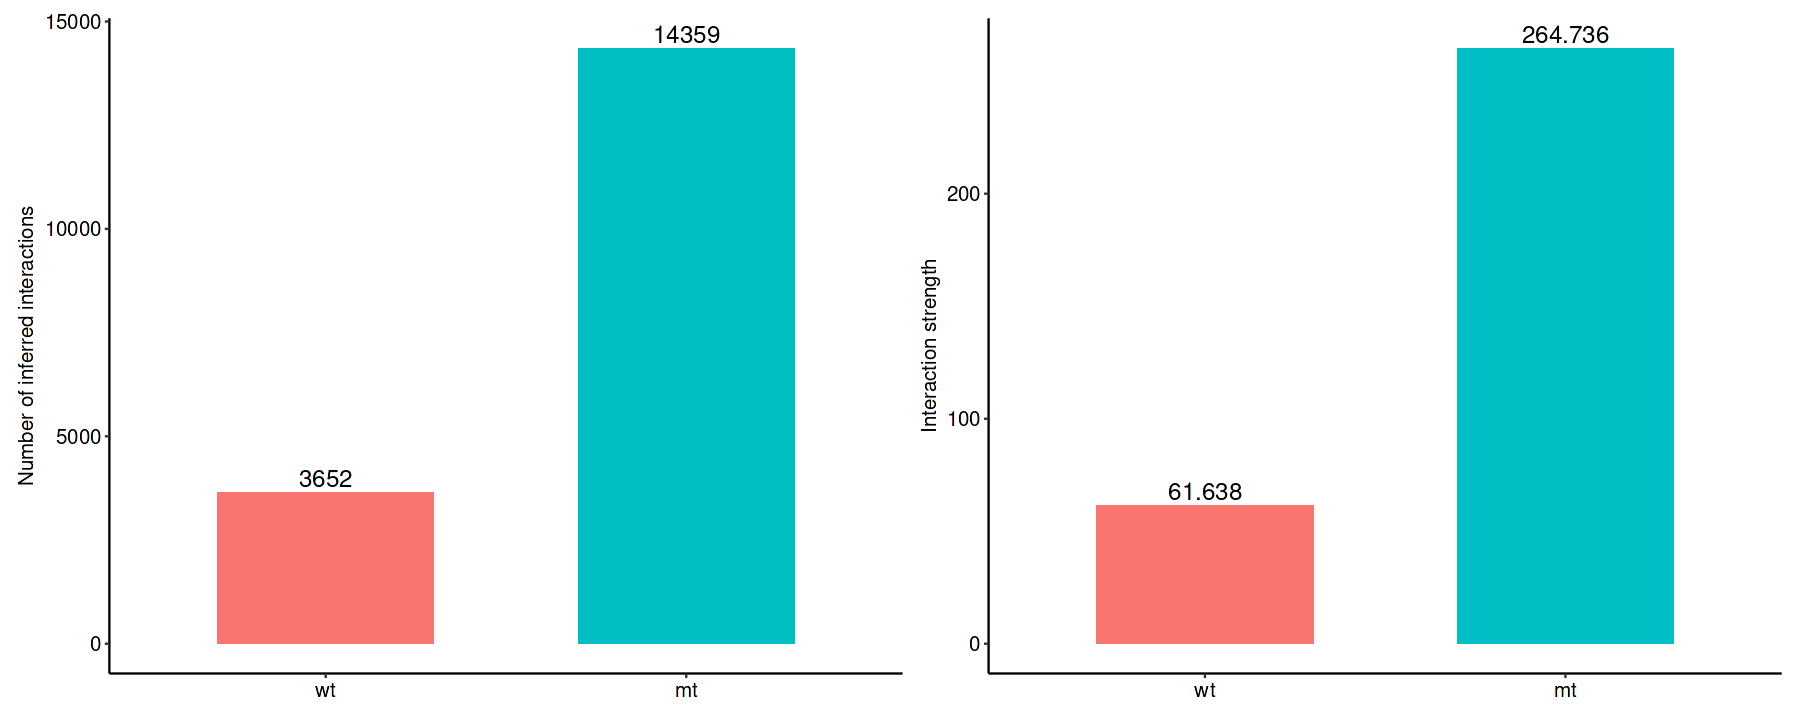

In [8]:
options(repr.plot.width = 15, repr.plot.height = 6)

# Generate the first plot (count-based)
gg1 <- compareInteractions(cellchat, show.legend = FALSE, group = c(1, 2))
gg1$layers[[2]]$aes_params$size <- 5  # Increase number labels above bars
gg1 <- gg1 + theme(
  axis.text = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size = 12, face = "bold"),
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 12)
)

# Generate the second plot (weight-based)
gg2 <- compareInteractions(cellchat, show.legend = FALSE, group = c(1, 2), measure = "weight")
gg2$layers[[2]]$aes_params$size <- 5  # Increase number labels above bars
gg2 <- gg2 + theme(
  axis.text = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size = 12, face = "bold"),
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 12)
)

# Combine and display the two plots
gg1 + gg2

# Combine plots
combined_plot <- gg1 + gg2

# Save as SVG
ggsave(
  filename = "projects/10_Axin_1_2/github_submission/outputs/7B/interaction_plot_combined.svg",  # update path here
  plot = combined_plot,
  width = 15, height = 6, dpi = 300,
  units = "in"
)

In [10]:
Hernandez_colors

ExE Ectoderm                      ExE Endoderm 
                        "#989898"                         "#7F6874" 
                Visceral Endoderm                          Epiblast 
                        "#F6BFCB"                         "#635547" 
                 Primitive Streak         Anterior Primitive Streak 
                        "#DABE99"                         "#FFA500" 
              Nascent mesoderm #1               Nascent mesoderm #2 
                        "#DDA0DD"                         "#5E2D79" 
Haematoendothelial progenitors #1 Haematoendothelial progenitors #2 
                        "#FBBE92"                         "#6c4b4c" 
       Posterior Primitive Streak  Posterior Lateral Plate Mesoderm 
                        "#5A5AC5"                         "#7F0000" 
                       Mesenchyme                Allantois Mesoderm 
                        "#e66100"                         "#3D99C3" 
            Intermediate Mesoderm                       Low Quality 
                        "#139992"                         "#D9D9D9" 
                Parietal Endoderm 
                        "#1A1A1A"

Do heatmap based on a merged object 


Do heatmap based on a merged object 




png 
  2

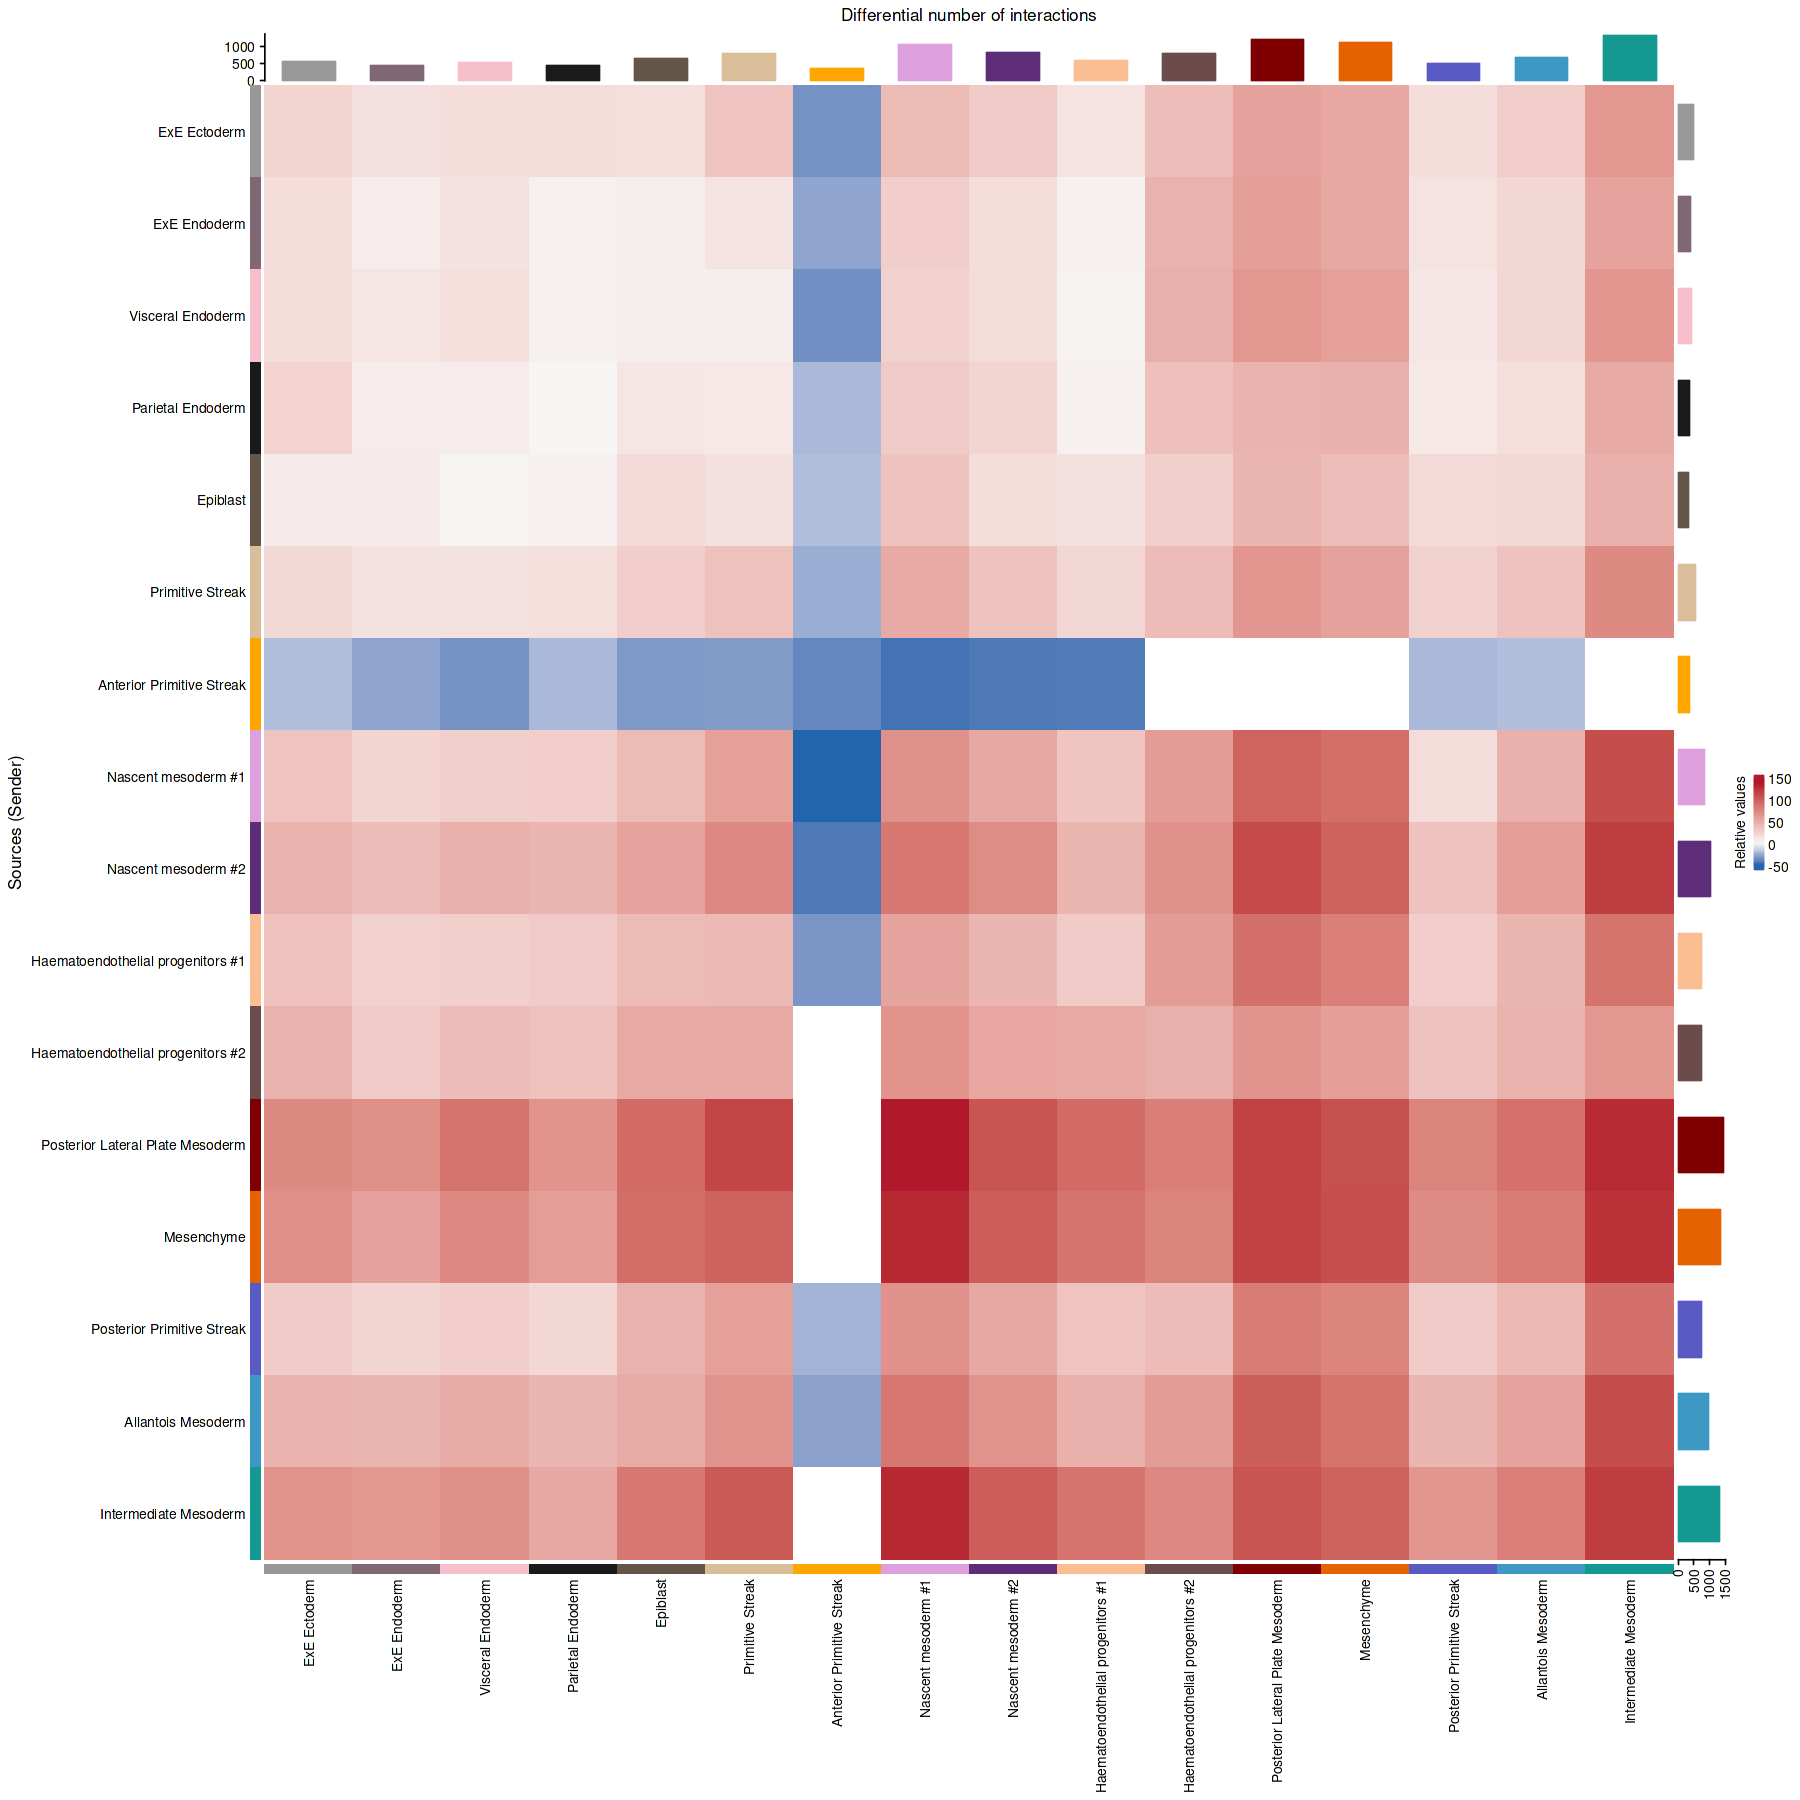

Cairo 
    3

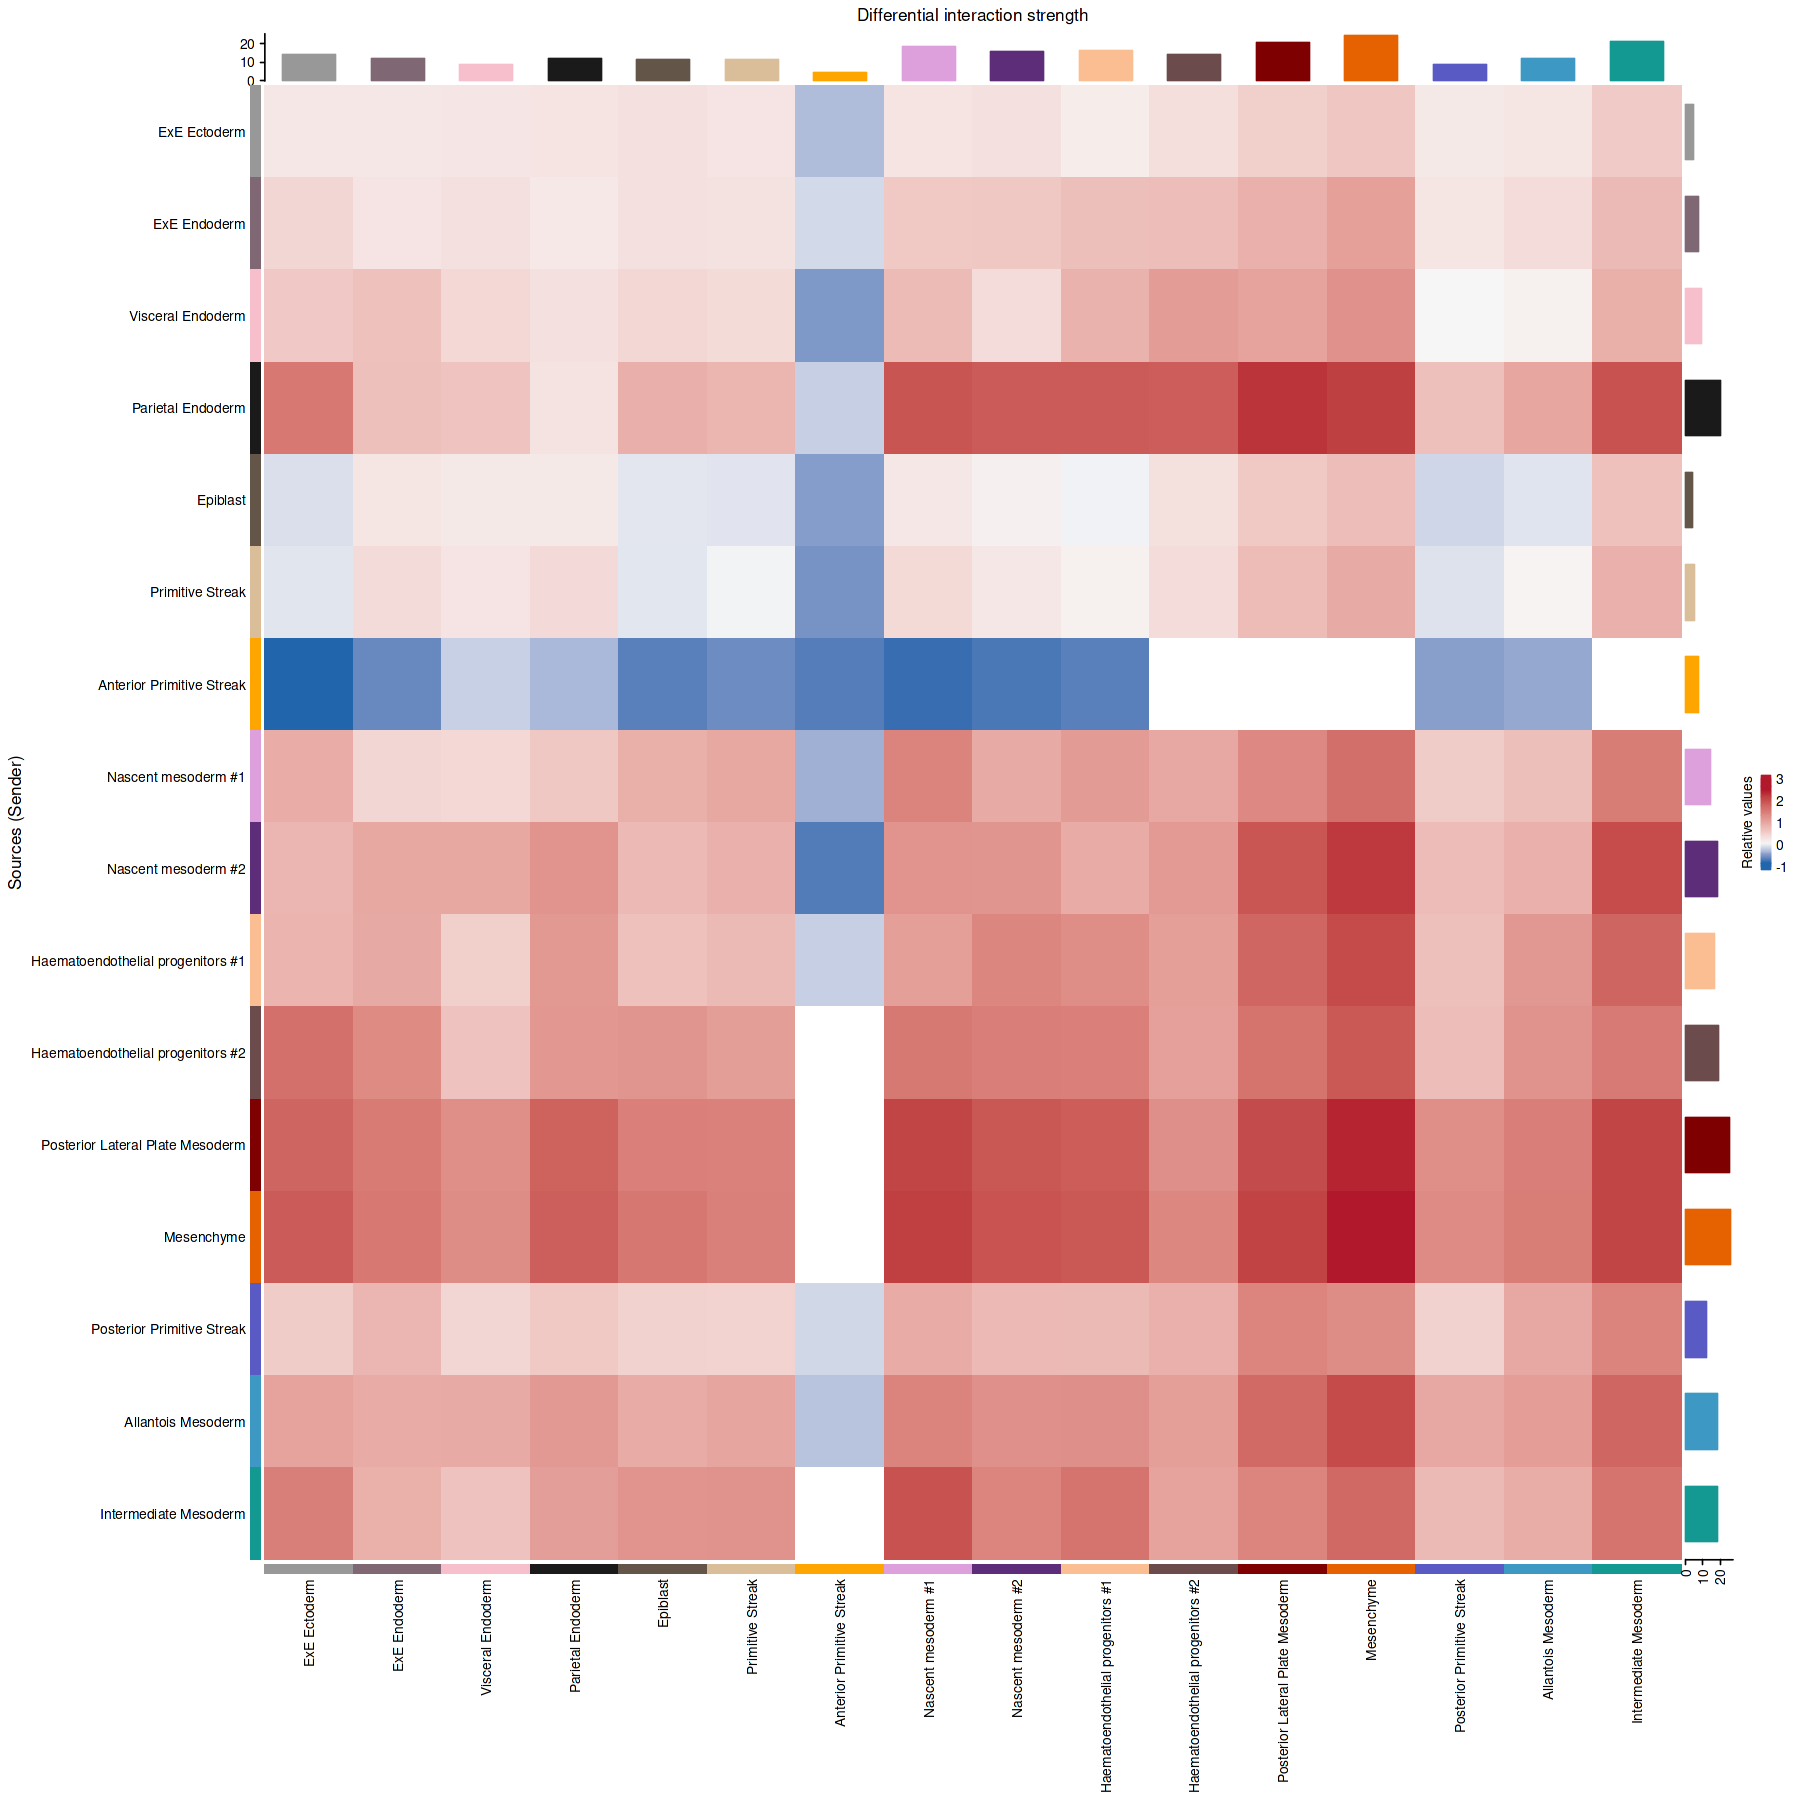

In [31]:
options(repr.plot.width = 15, repr.plot.height = 15)

gg1 <- netVisual_heatmap(cellchat, color.use = Hernandez_colors_filtered)
gg2 <- netVisual_heatmap(cellchat, measure = "weight", color.use = Hernandez_colors_filtered)

# Save to SVG using grid graphics
CairoPNG(file = "projects/10_Axin_1_2/github_submission/outputs/7B/differential_number_interactions_heatmap.png",
         width = 1500, height = 1500, res = 300)

draw(gg1)  # or use print(gg1) if needed
dev.off()

# Save to SVG using grid graphics
CairoPNG(file = "projects/10_Axin_1_2/github_submission/outputs/7B/differential_interactions_strength_heatmap.png",
         width = 1500, height = 1500, res = 300)

draw(gg2)  # or use print(gg1) if needed
dev.off()

Do heatmap based on a merged object 


Do heatmap based on a merged object 




png 
  2

png 
  2

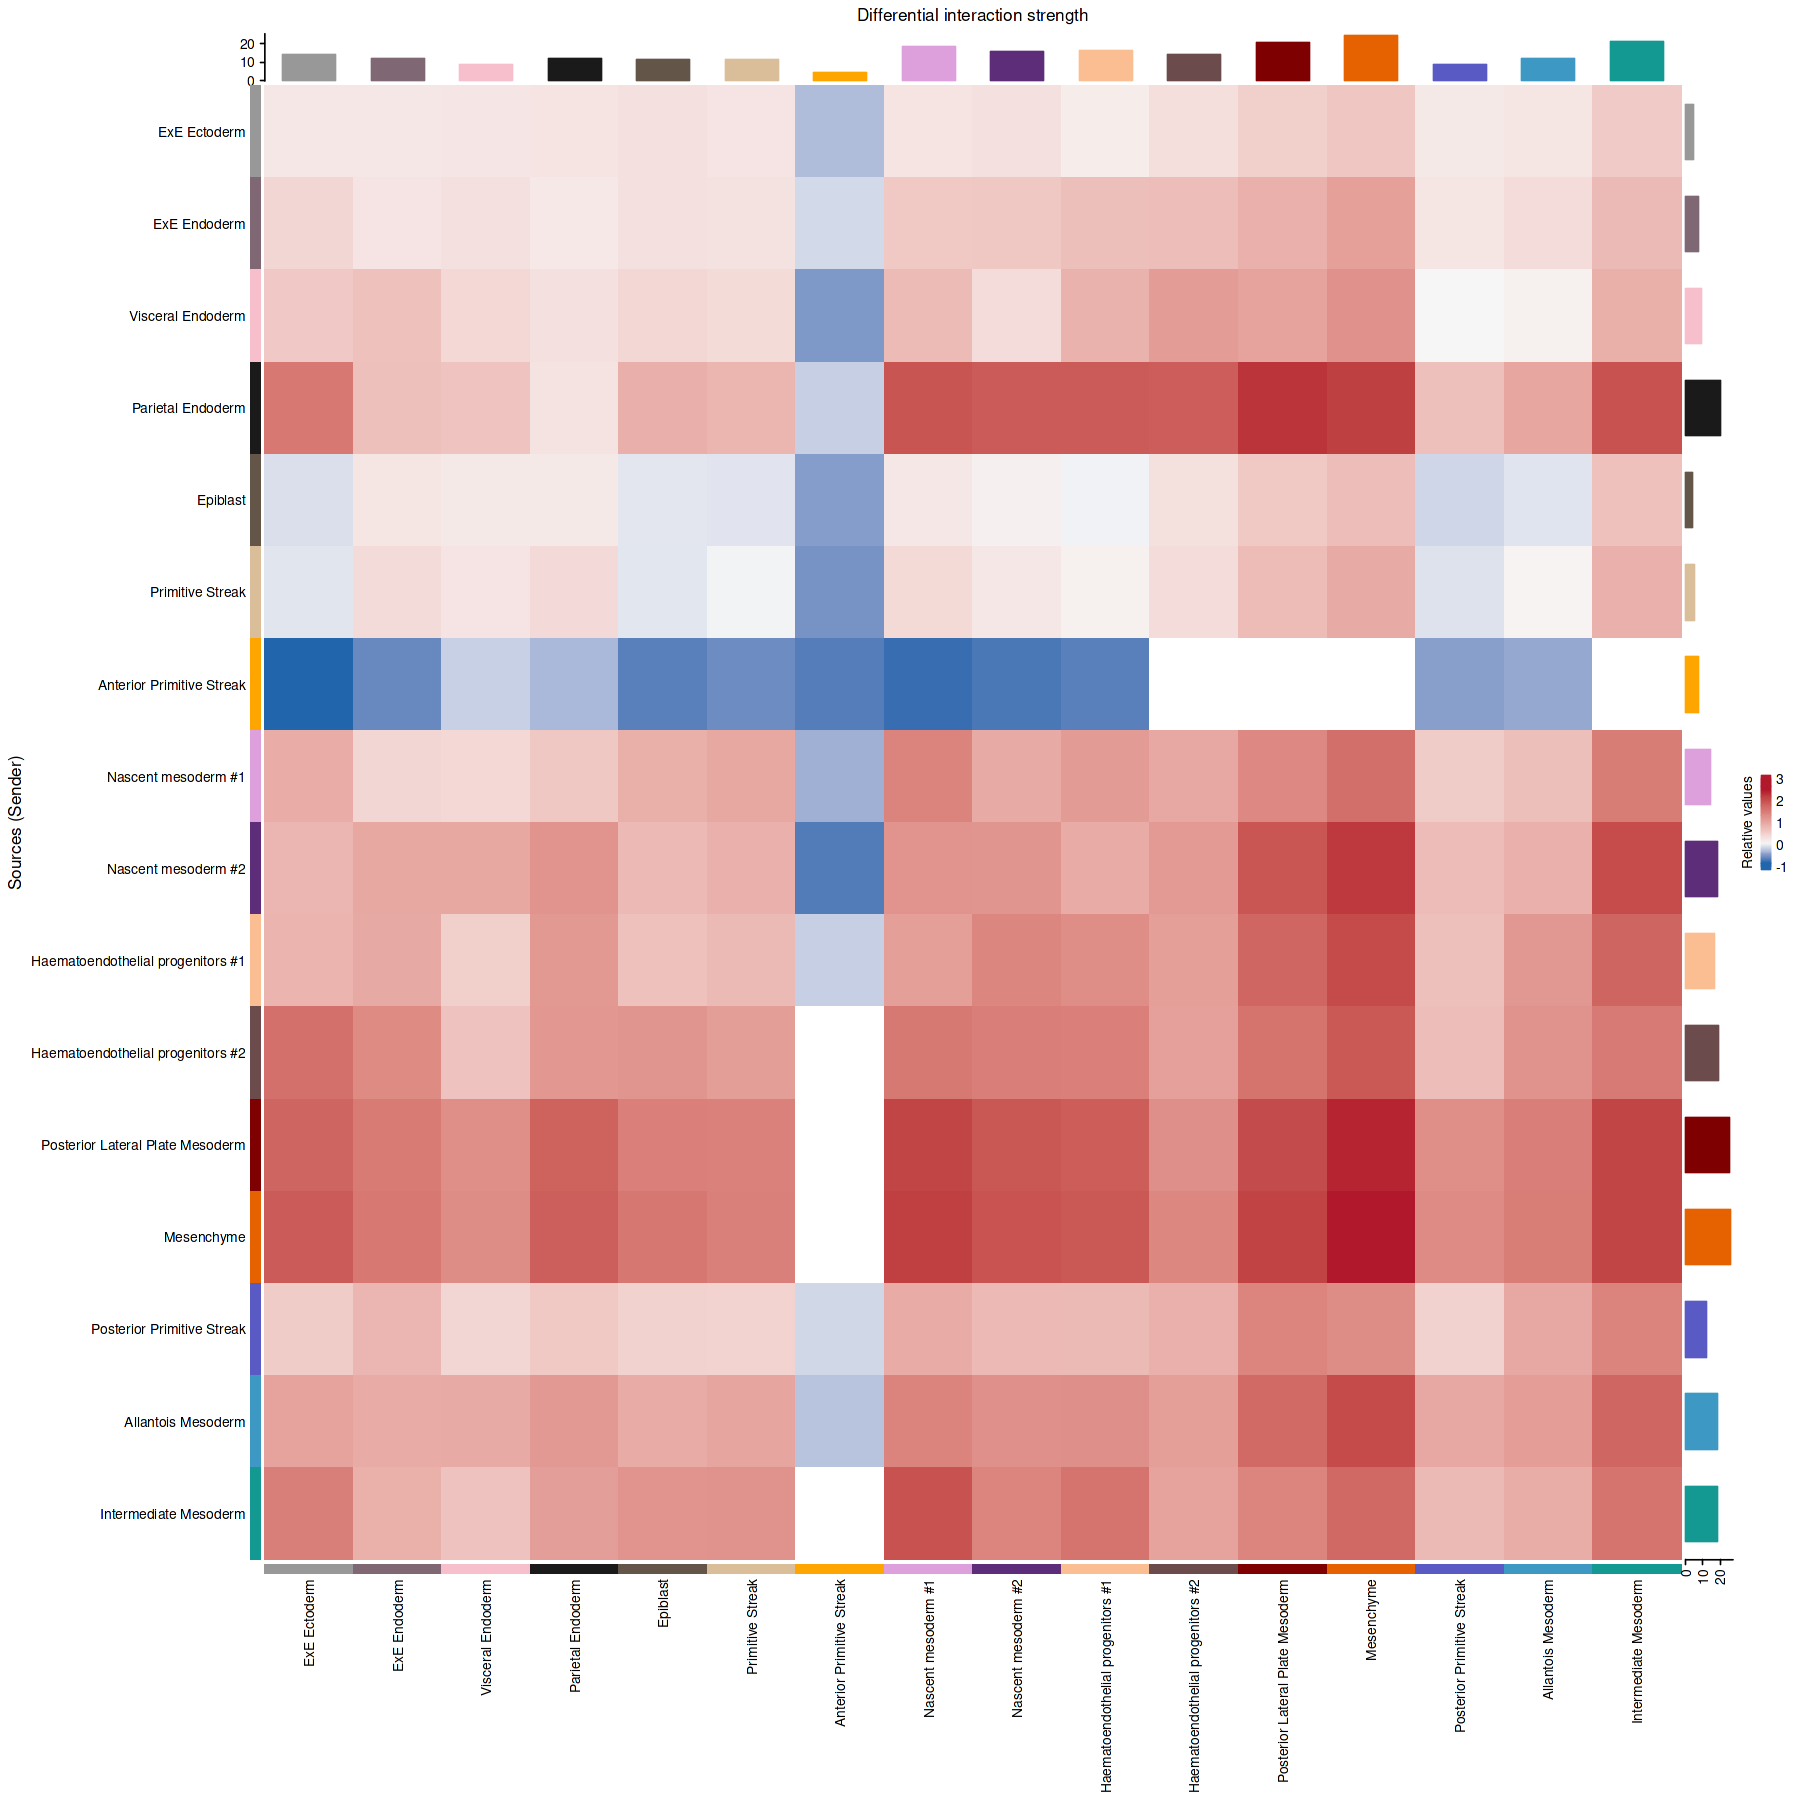

In [32]:
library(ComplexHeatmap)
library(grid)

options(repr.plot.width = 15, repr.plot.height = 15)

# Generate the heatmaps
gg1 <- netVisual_heatmap(cellchat, color.use = Hernandez_colors_filtered)
gg2 <- netVisual_heatmap(cellchat, measure = "weight", color.use = Hernandez_colors_filtered)

# --- Save gg1: Differential Number of Interactions ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/differential_number_interactions_heatmap.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE  # for Illustrator compatibility
)
grid.newpage()
draw(gg1, ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save gg2: Differential Interaction Strength ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/differential_interactions_strength_heatmap.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE
)
grid.newpage()
draw(gg2, ht_gap = unit(0.5, "cm"))
dev.off()

Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


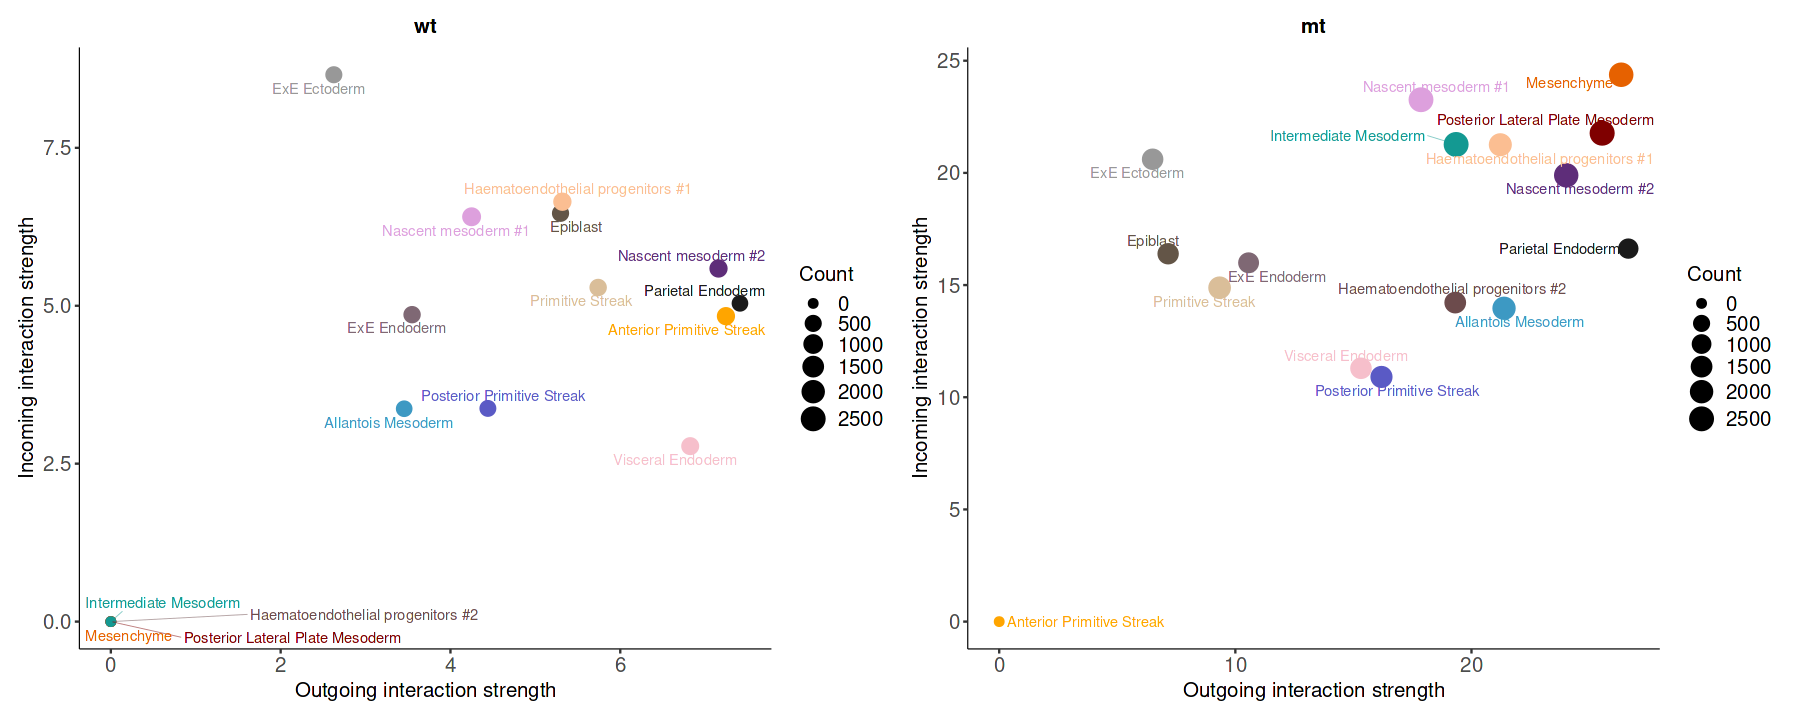

In [33]:
options(repr.plot.width = 15, repr.plot.height = 6)

# Compare the major sources and targets in a 2D space
# (A) Identify cell populations with significant changes in sending or receiving signals
num.link <- sapply(object.list, function(x) {
  rowSums(x@net$count) + colSums(x@net$count) - diag(x@net$count)
})
weight.MinMax <- c(min(num.link), max(num.link)) # control the dot size in the different datasets

gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]],
                                               title = names(object.list)[i],
                                               weight.MinMax = weight.MinMax) +
    scale_color_manual(values = Hernandez_colors_filtered) +
    theme(
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 12),
      legend.title = element_text(size = 12)
    )
}

patchwork::wrap_plots(plots = gg)

# Combine the plots
combined_plot <- patchwork::wrap_plots(plots = gg)

# Save as SVG to a specific file location
ggsave(
  filename = "projects/10_Axin_1_2/github_submission/outputs/7B/signaling_role_scatter.svg",  # 🔁 update this path
  plot = combined_plot,
  width = 15,
  height = 6,
  units = "in",
  dpi = 300
)

Visualizing differential outgoing and incoming signaling changes from wt to mt

Visualizing differential outgoing and incoming signaling changes from wt to mt

Visualizing differential outgoing and incoming signaling changes from wt to mt

Visualizing differential outgoing and incoming signaling changes from wt to mt



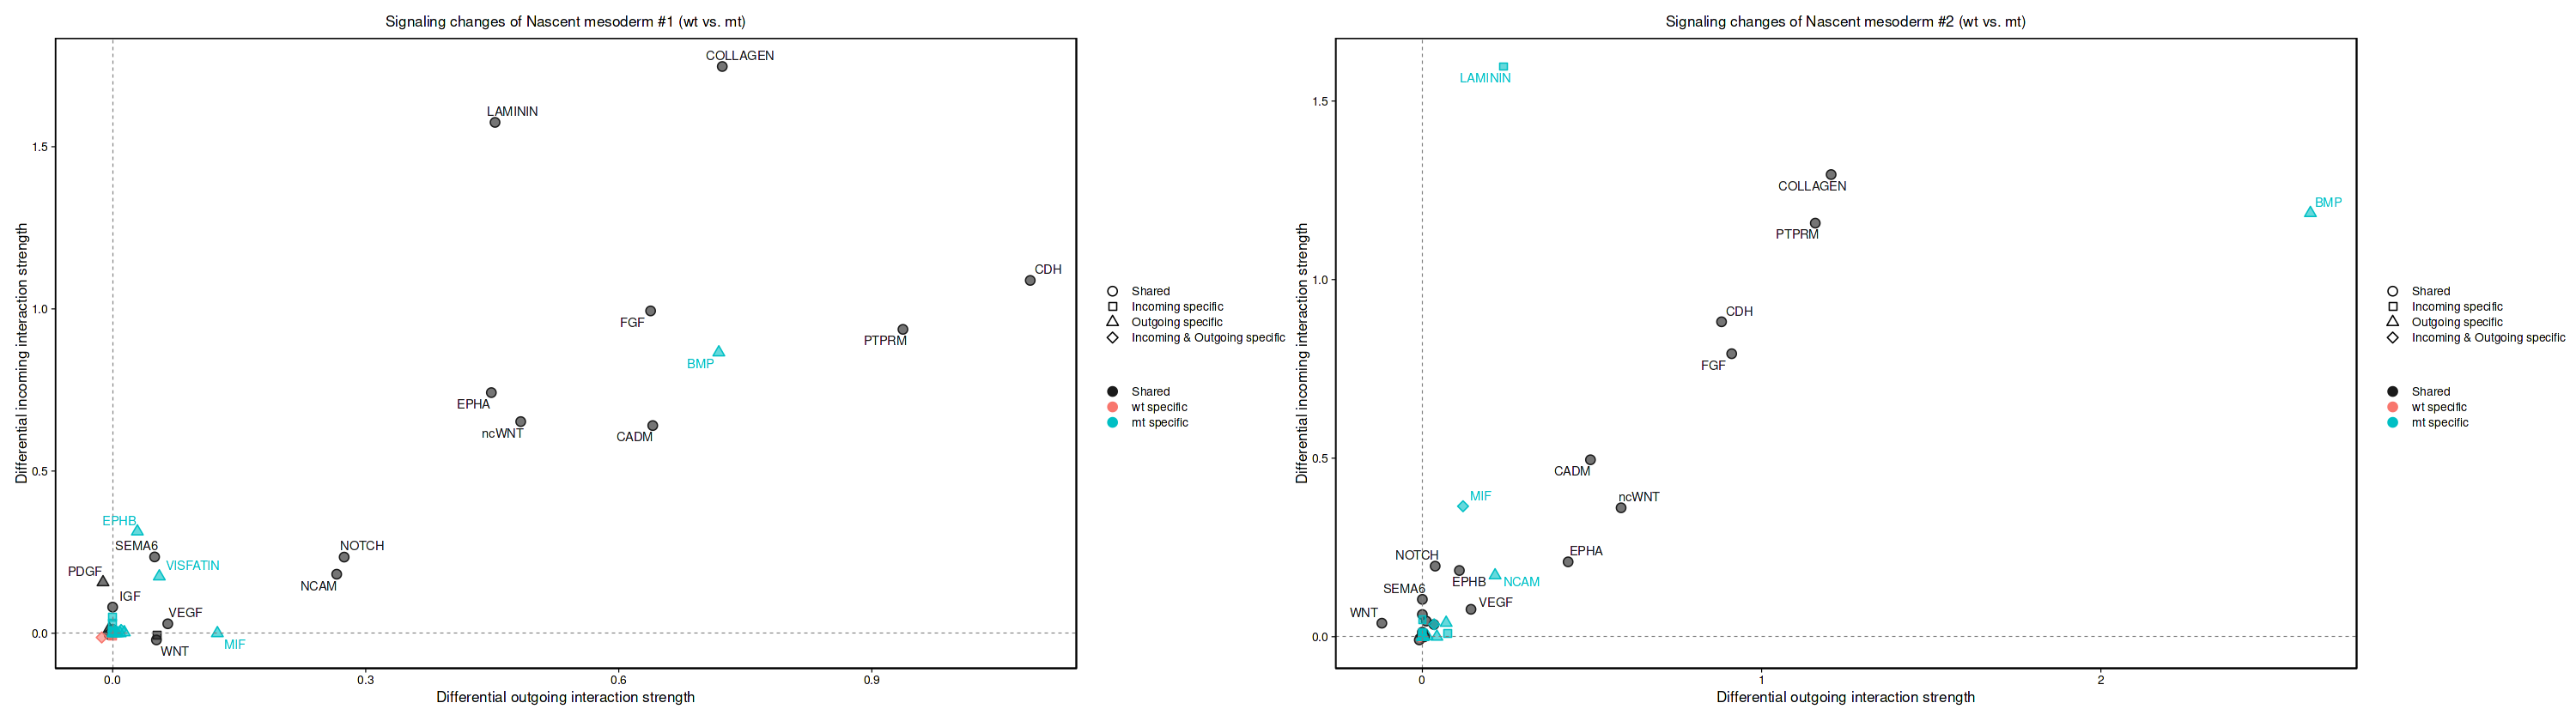

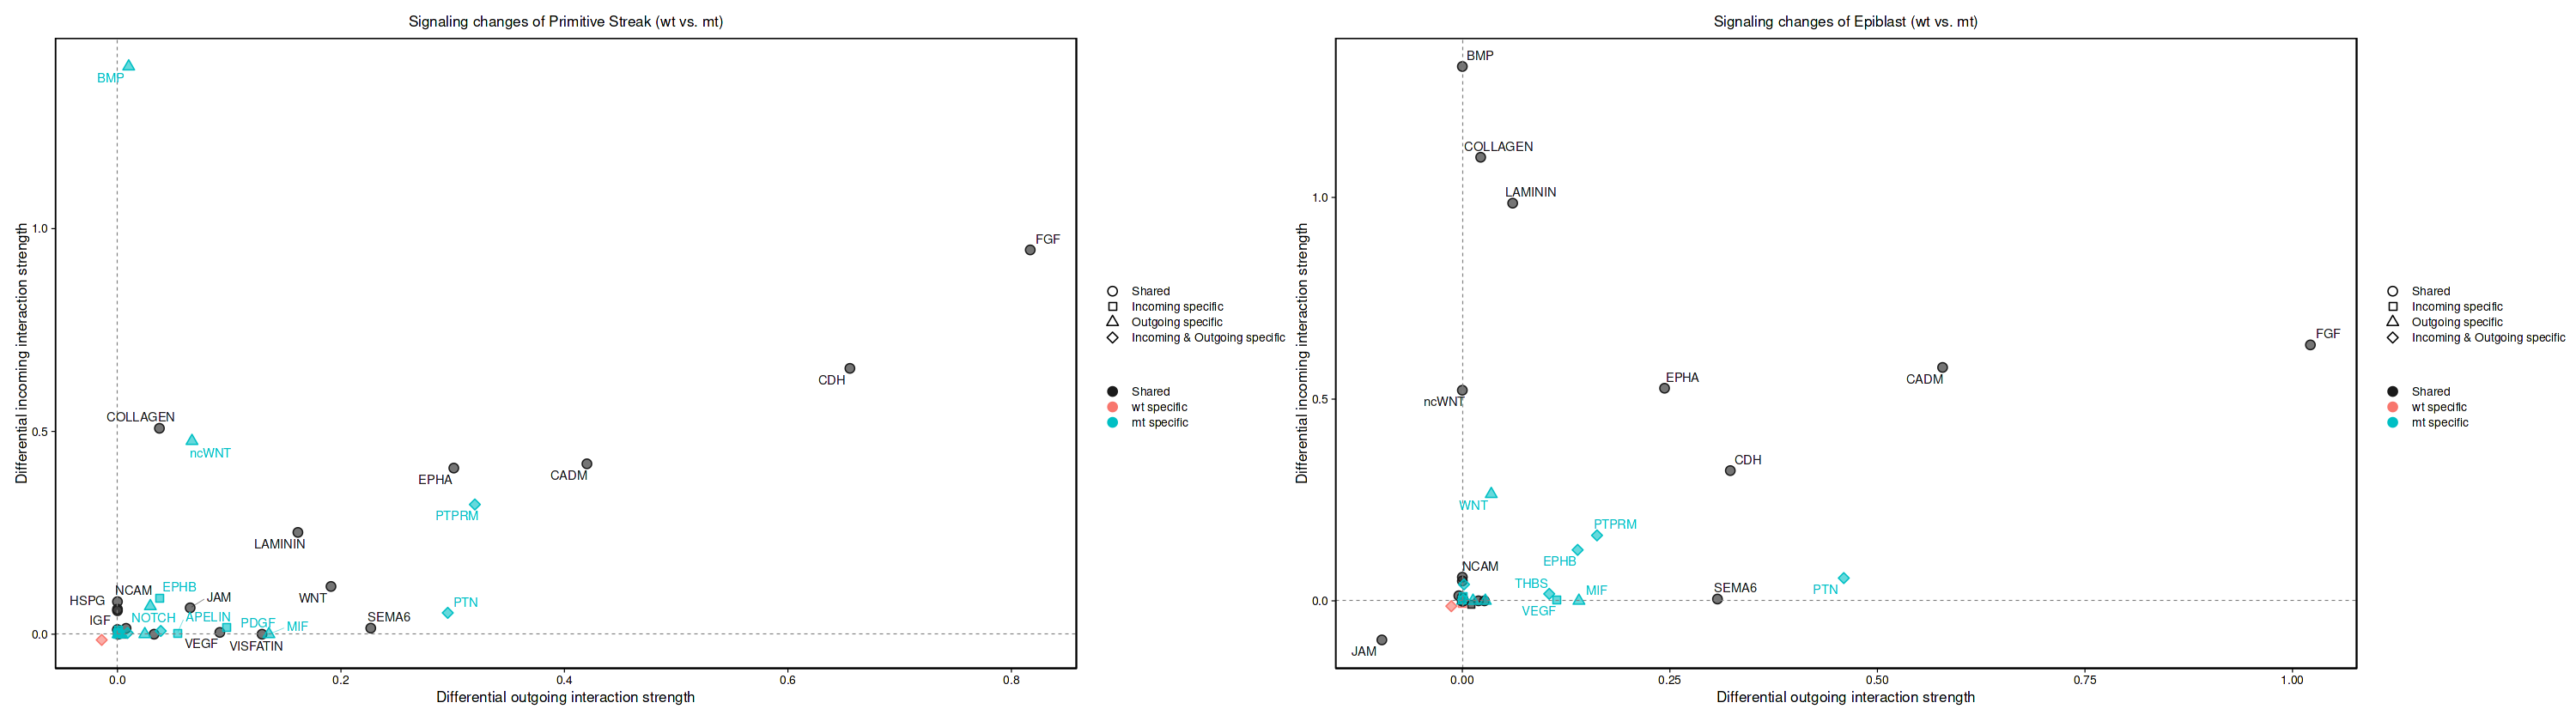

In [34]:
options(repr.plot.width = 25, repr.plot.height = 7)

# (B) Identify the signaling changes of specific cell populations
gg1 <- netAnalysis_signalingChanges_scatter(cellchat, idents.use = "Nascent mesoderm #1", signaling.exclude = c("MK", "FN1"))
#> Visualizing differential outgoing and incoming signaling changes from NL to LS
#> The following `from` values were not present in `x`: 0
#> The following `from` values were not present in `x`: 0, -1
gg2 <- netAnalysis_signalingChanges_scatter(cellchat, idents.use = "Nascent mesoderm #2", signaling.exclude = c("MK", "FN1"))
#> Visualizing differential outgoing and incoming signaling changes from NL to LS
#> The following `from` values were not present in `x`: 0, 2
#> The following `from` values were not present in `x`: 0, -1
gg3 <- netAnalysis_signalingChanges_scatter(cellchat, idents.use = "Primitive Streak", signaling.exclude = c("MK", "FN1"))
#> Visualizing differential outgoing and incoming signaling changes from NL to LS
#> The following `from` values were not present in `x`: 0, 2
#> The following `from` values were not present in `x`: 0, -1
gg4 <- netAnalysis_signalingChanges_scatter(cellchat, idents.use = "Epiblast", signaling.exclude = c("MK", "FN1"))
#> Visualizing differential outgoing and incoming signaling changes from NL to LS
#> The following `from` values were not present in `x`: 0, 2
#> The following `from` values were not present in `x`: 0, -1
patchwork::wrap_plots(plots = list(gg1,gg2))
patchwork::wrap_plots(plots = list(gg3,gg4))

# Combine the first two plots
combined_plot_1 <- wrap_plots(plots = list(gg1, gg2))

# Save the first SVG
ggsave(
  filename = "projects/10_Axin_1_2/github_submission/outputs/7B/signaling_changes_nascent_ps.svg",  # update this
  plot = combined_plot_1,
  width = 25,
  height = 7,
  units = "in",
  dpi = 300
)

# Combine the next two plots
combined_plot_2 <- wrap_plots(plots = list(gg3, gg4))

# Save the second SVG
ggsave(
  filename = "projects/10_Axin_1_2/github_submission/outputs/7B/signaling_changes_primitive_epiblast.svg",  # update this
  plot = combined_plot_2,
  width = 25,
  height = 7,
  units = "in",
  dpi = 300
)

## Part 2: Identify the altered signaling with network architecture and interaction strength

In [35]:
##cellchat <- computeNetSimilarityPairwise(cellchat, type = "functional")
#> Compute signaling network similarity for datasets 1 2
##cellchat <- netEmbedding(cellchat, type = "functional")
#> Manifold learning of the signaling networks for datasets 1 2
##cellchat <- netClustering(cellchat, type = "functional")
#> Classification learning of the signaling networks for datasets 1 2
# Visualization in 2D-space
##netVisual_embeddingPairwise(cellchat, type = "functional", label.size = 3.5)
#> 2D visualization of signaling networks from datasets 1 2

In [36]:
options(repr.plot.width = 15, repr.plot.height = 10)

# (A) Compare the overall information flow of each signaling pathway or ligand-receptor pair
gg1 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = NULL, targets.use = NULL, stacked = T, do.stat = TRUE)
gg2 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = NULL, targets.use = NULL, stacked = F, do.stat = TRUE)

# Combine the two rankNet plots
combined_rankNet_plot <- gg1 + gg2

# Save as SVG
ggsave(
  filename = "projects/10_Axin_1_2/github_submission/outputs/7B/rankNet_information_flow.svg",  # 🔁 update this path
  plot = combined_rankNet_plot,
  width = 15,
  height = 10,
  units = "in",
  dpi = 300
)

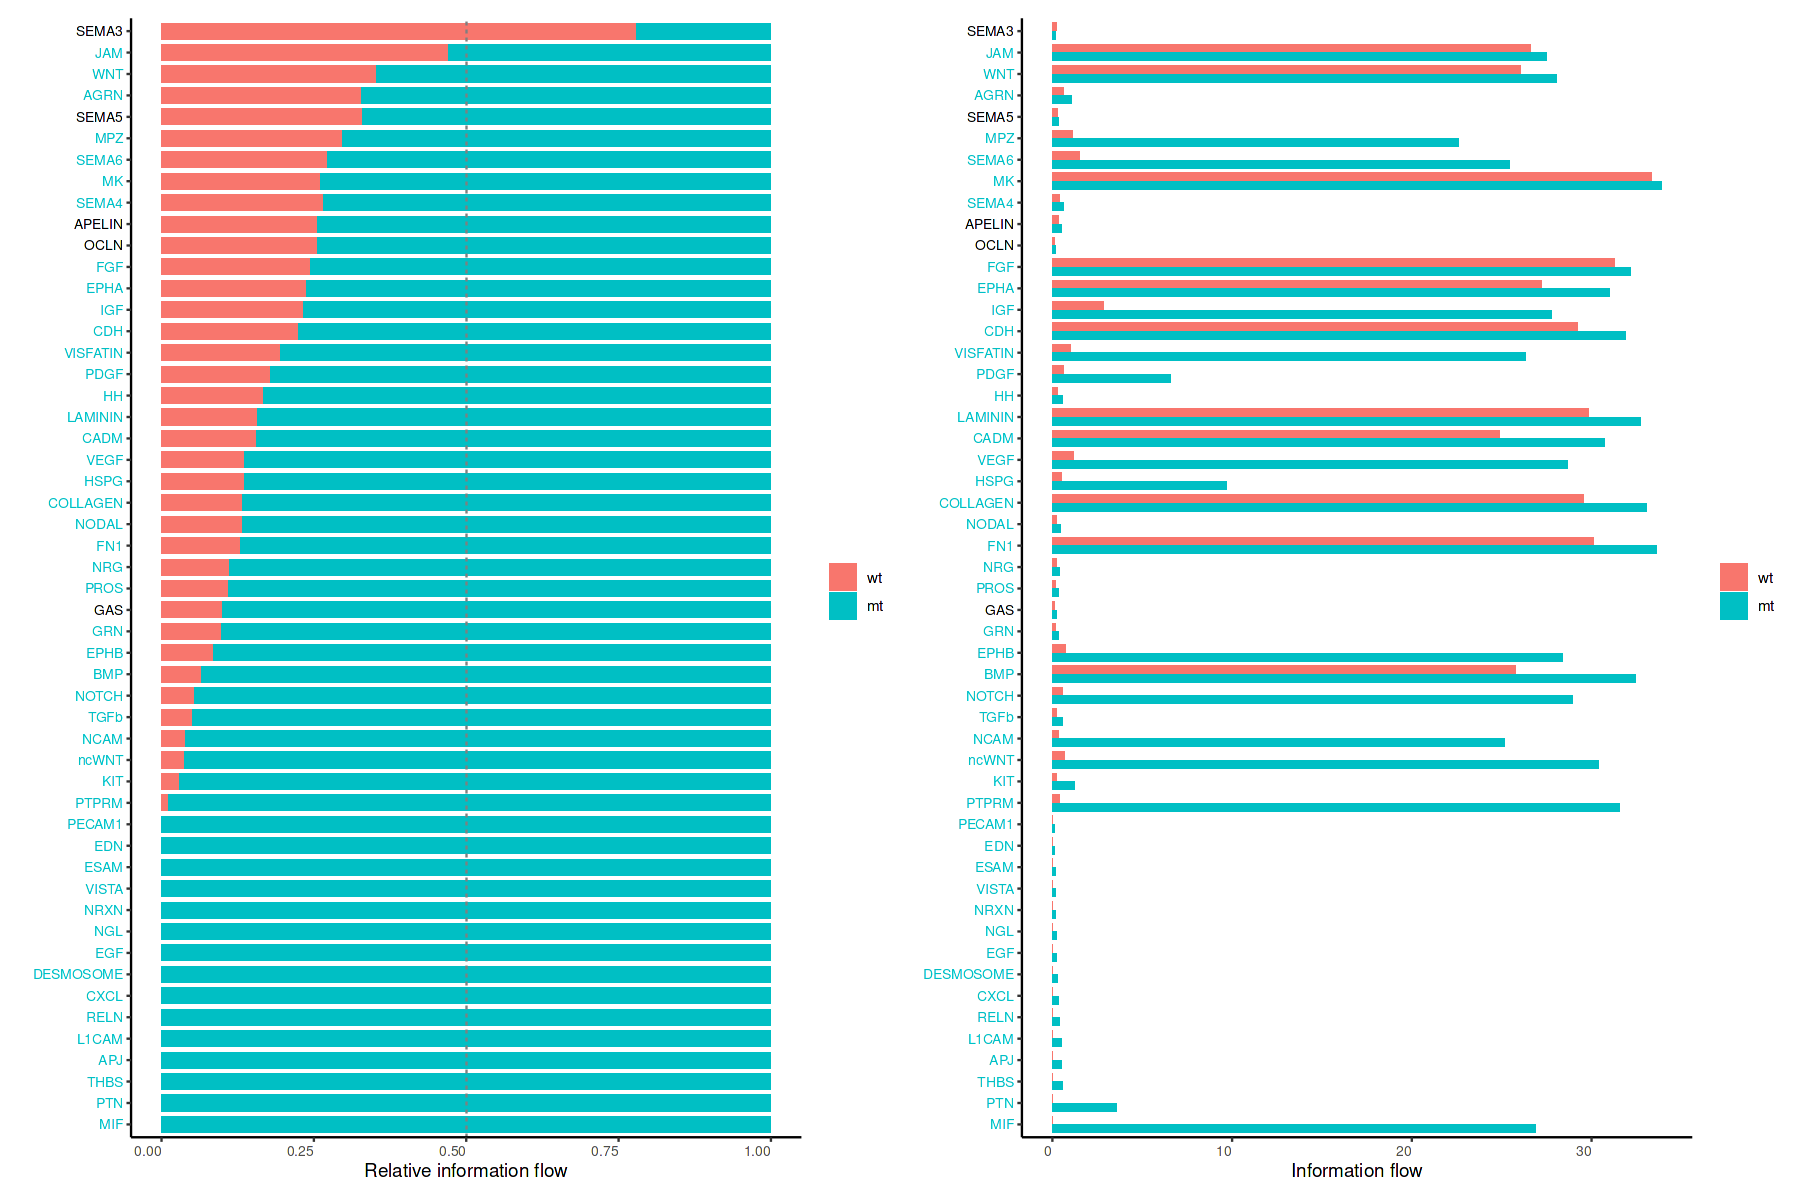

In [37]:
combined_rankNet_plot

png 
  2

png 
  2

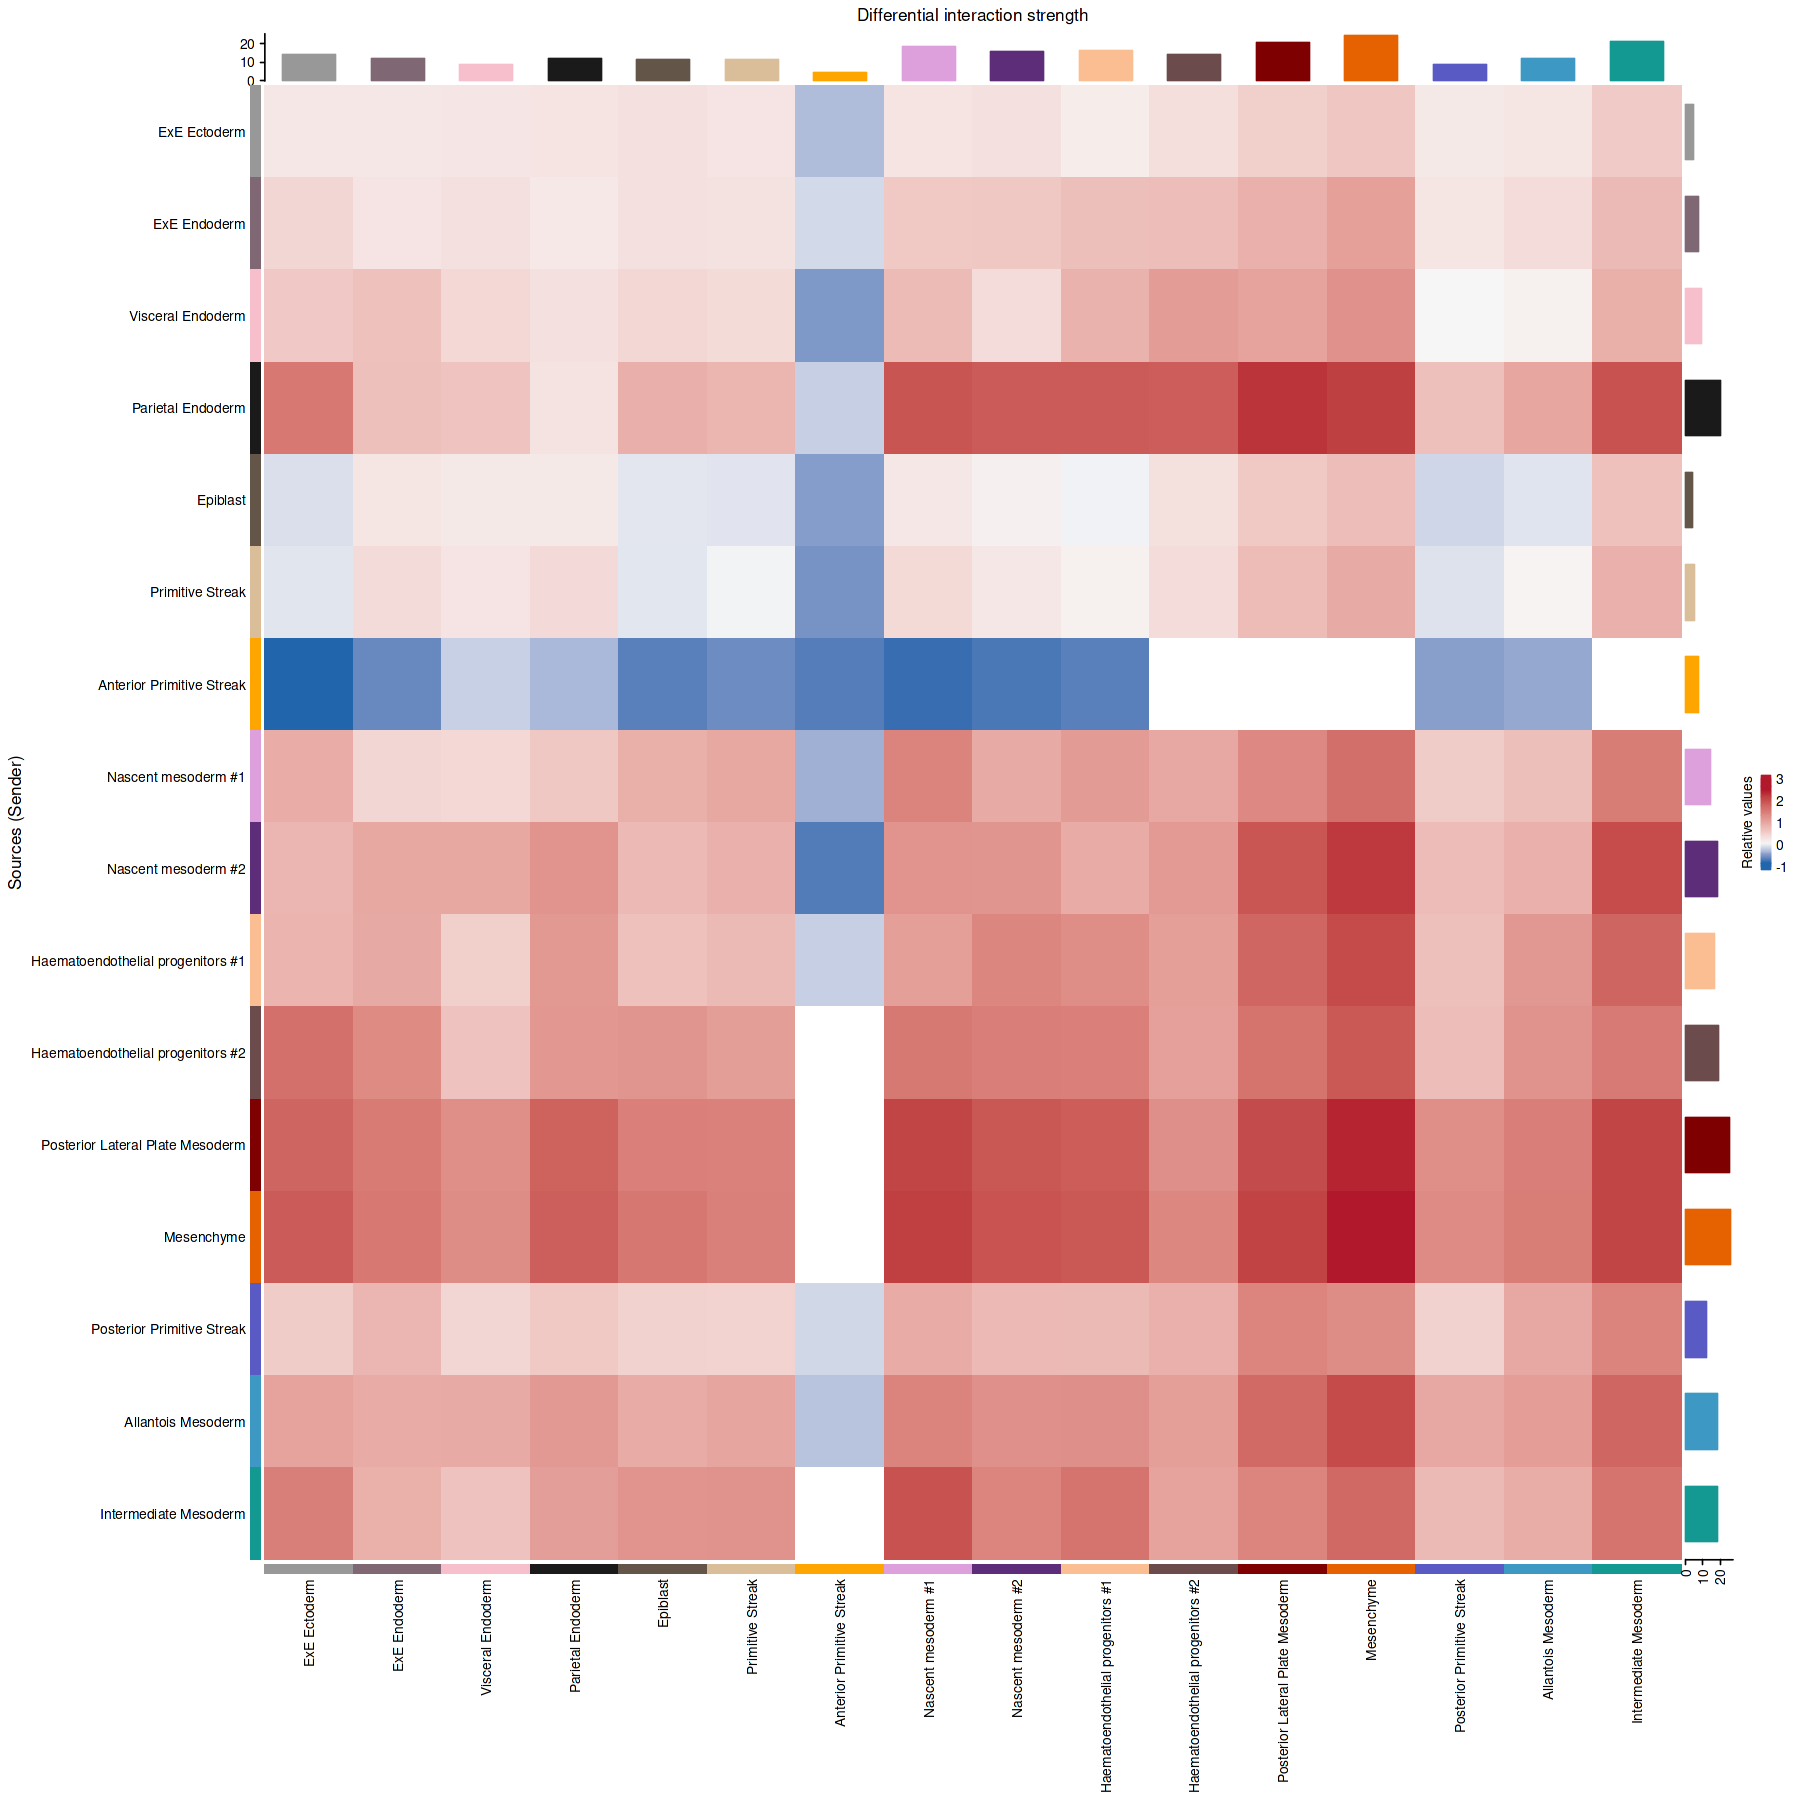

In [38]:
library(ComplexHeatmap)
library(grid)

options(repr.plot.width = 15, repr.plot.height = 15)

i <- 1
# Combine pathways across the datasets
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i + 1]]@netP$pathways)

# Generate the heatmap objects
ht1 <- netAnalysis_signalingRole_heatmap(
  object.list[[i]],
  pattern = "incoming",
  signaling = pathway.union,
  title = names(object.list)[i],
  width = 15,
  height = 15,
  color.use = Hernandez_colors_filtered
)

ht2 <- netAnalysis_signalingRole_heatmap(
  object.list[[i + 1]],
  pattern = "incoming",
  signaling = pathway.union,
  title = names(object.list)[i + 1],
  width = 15,
  height = 15,
  color.use = Hernandez_colors_filtered
)

# --- Save ht1 to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/signalingRole_heatmap_WT_incoming.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE
)
grid.newpage()
draw(ht1, ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht2 to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/signalingRole_heatmap_MT_incoming.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE
)
grid.newpage()
draw(ht2, ht_gap = unit(0.5, "cm"))
dev.off()

png 
  2

png 
  2

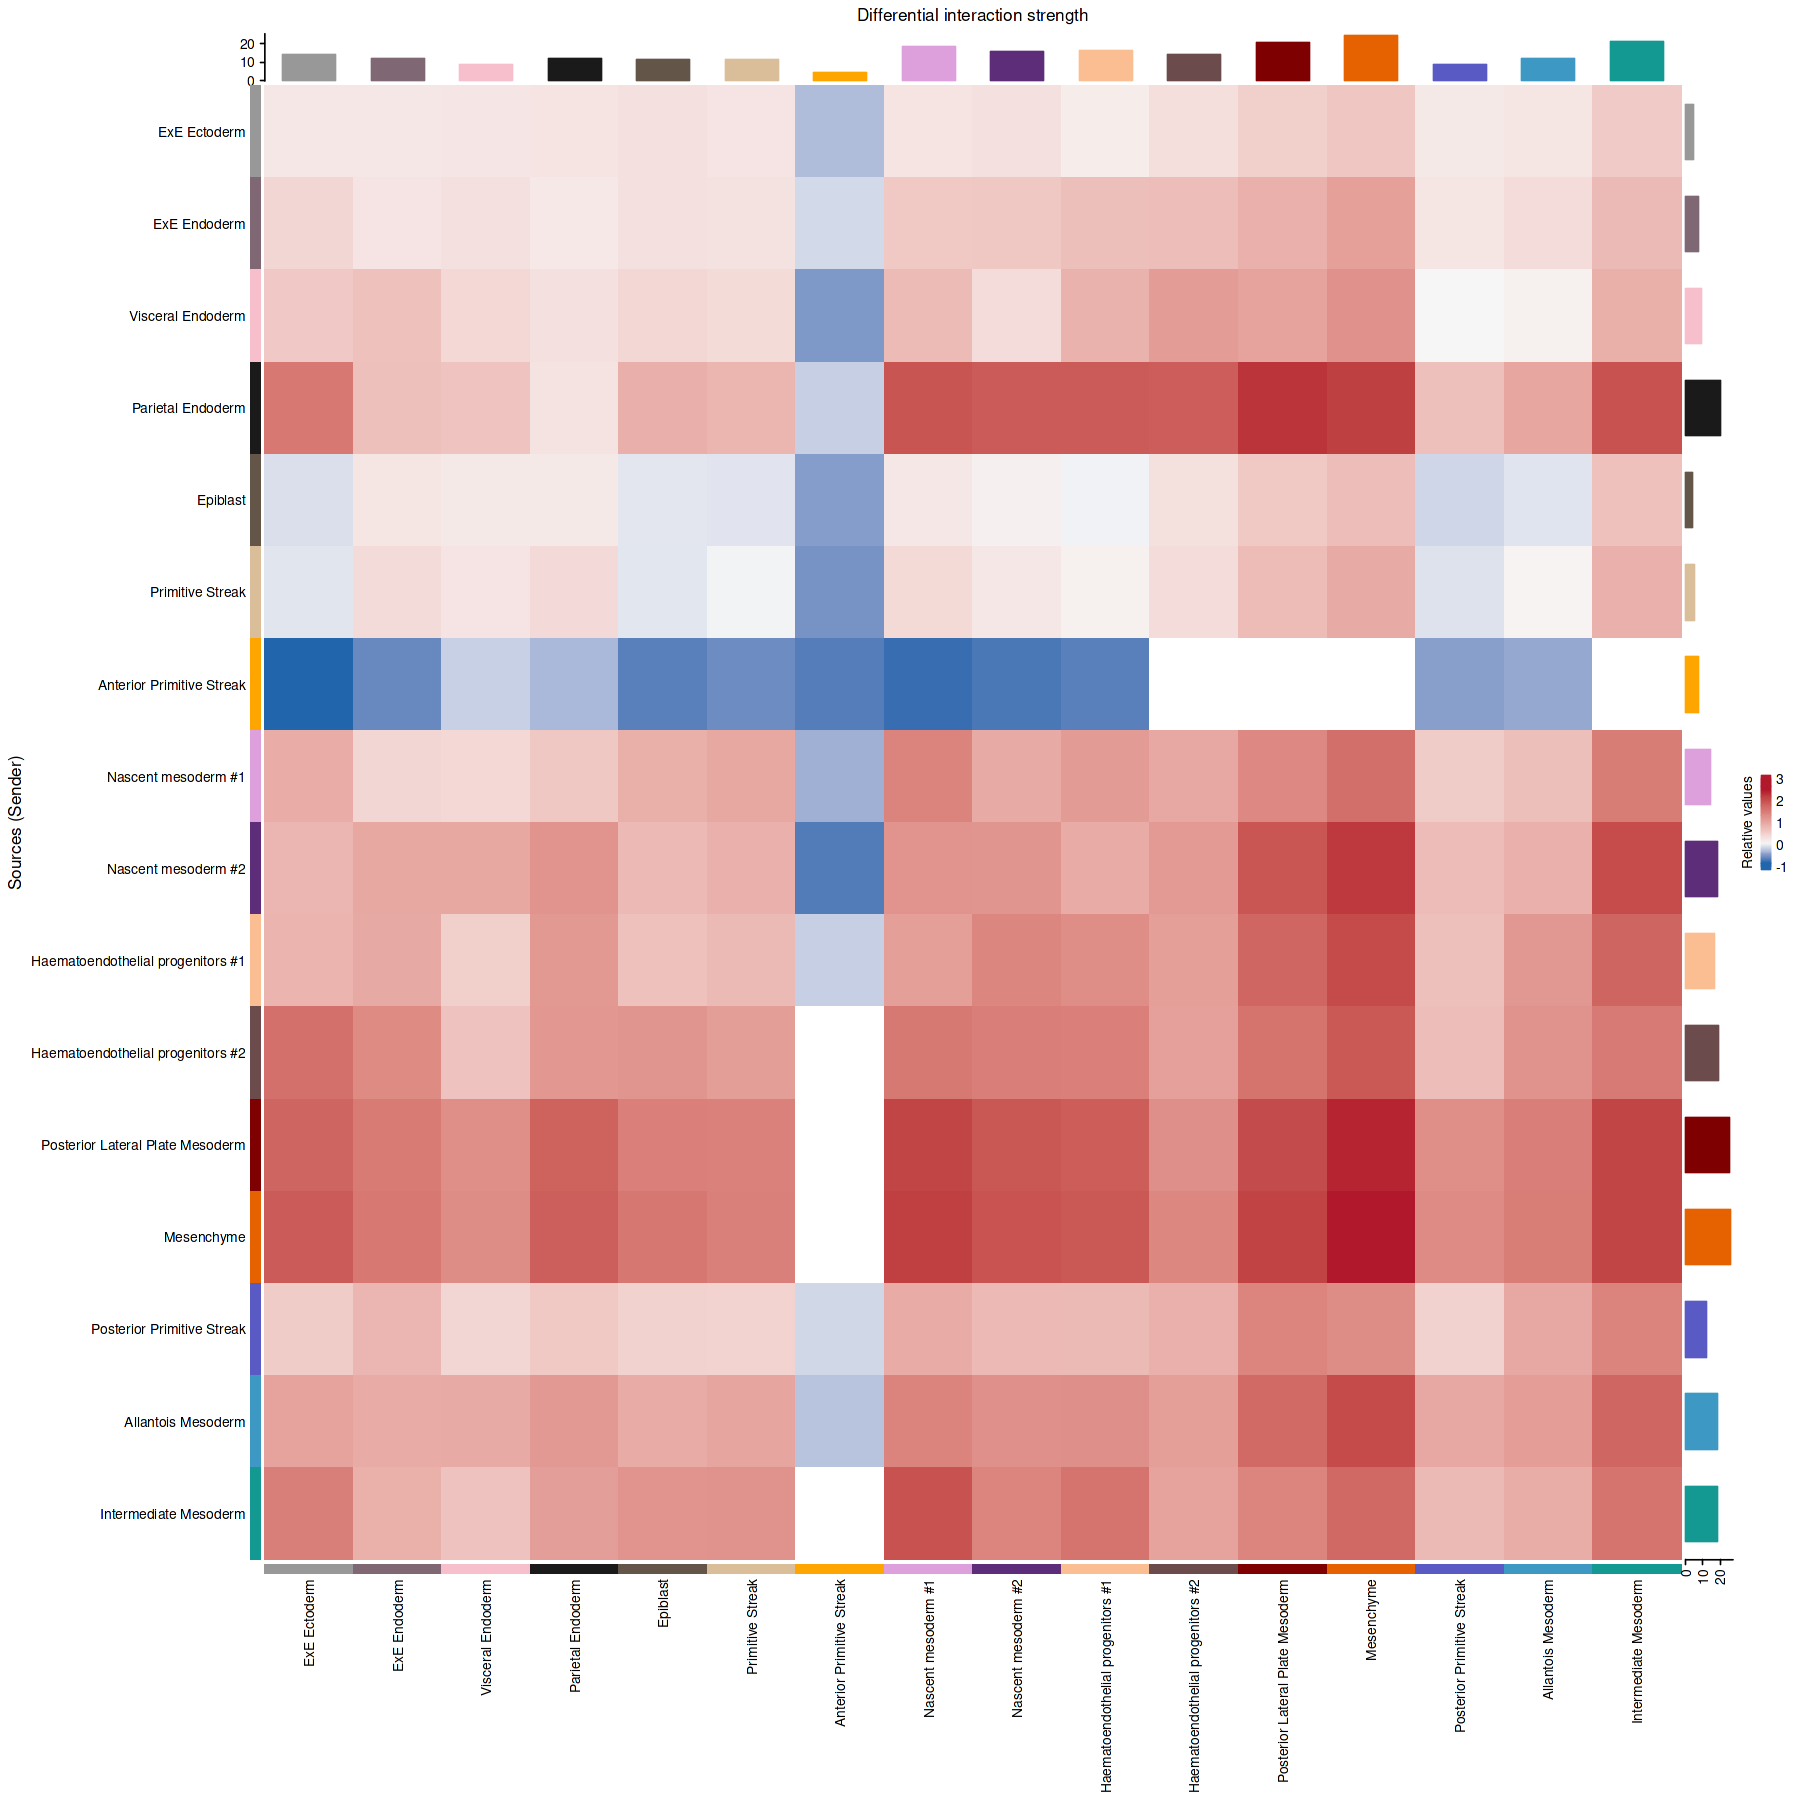

In [39]:
library(ComplexHeatmap)
library(grid)

options(repr.plot.width = 15, repr.plot.height = 15)

i <- 1
# Combine pathways across the datasets
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i + 1]]@netP$pathways)

# Generate the heatmap objects
ht1 <- netAnalysis_signalingRole_heatmap(
  object.list[[i]],
  pattern = "outgoing",
  signaling = pathway.union,
  title = names(object.list)[i],
  width = 15,
  height = 15,
  color.use = Hernandez_colors_filtered
)

ht2 <- netAnalysis_signalingRole_heatmap(
  object.list[[i + 1]],
  pattern = "outgoing",
  signaling = pathway.union,
  title = names(object.list)[i + 1],
  width = 15,
  height = 15,
  color.use = Hernandez_colors_filtered
)

# --- Save ht1 to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/signalingRole_heatmap_WT_outgoing.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE
)
grid.newpage()
draw(ht1, ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht2 to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/signalingRole_heatmap_MT_outgoing.pdf",
  width = 15,
  height = 15,
  useDingbats = FALSE
)
grid.newpage()
draw(ht2, ht_gap = unit(0.5, "cm"))
dev.off()

## Part IV: Visually Compare Cell Communication using Different Plots

In [40]:
# Define output file
png("projects/10_Axin_1_2/github_submission/outputs/7B/BMP_network_comparison.png", 
    width = 1500*2, height = 750*2, res = 300)

# Plot layout for side-by-side plots
par(mfrow = c(1, 2), xpd = TRUE)

# Set up pathway and edge weight control
pathways.show <- c("BMP")
weight.max <- getMaxWeight(object.list, slot.name = "netP", attribute = pathways.show)

# Loop and plot to SVG
for (i in 1:length(object.list)) {
  netVisual_aggregate(
    object.list[[i]],
    signaling = pathways.show,
    layout = "circle",
    color.use = Hernandez_colors_filtered,
    edge.weight.max = weight.max[1],
    edge.width.max = 10,
    signaling.name = paste(pathways.show, names(object.list)[i])
  )
}

# Close the SVG device
dev.off()

png 
  2

In [41]:
# Define output file
png("projects/10_Axin_1_2/github_submission/outputs/7B/NODAL_network_comparison.png", 
    width = 1500*2, height = 750*2, res = 300)

# Plot layout for side-by-side plots
par(mfrow = c(1, 2), xpd = TRUE)

# Set up pathway and edge weight control
pathways.show <- c("NODAL")
weight.max <- getMaxWeight(object.list, slot.name = "netP", attribute = pathways.show)

# Loop and plot to SVG
for (i in 1:length(object.list)) {
  netVisual_aggregate(
    object.list[[i]],
    signaling = pathways.show,
    layout = "circle",
    color.use = Hernandez_colors_filtered,
    edge.weight.max = weight.max[1],
    edge.width.max = 10,
    signaling.name = paste(pathways.show, names(object.list)[i])
  )
}

# Close the SVG device
dev.off()

png 
  2

In [42]:
# Define output file
png("projects/10_Axin_1_2/github_submission/outputs/7B/WNT_network_comparison.png", 
    width = 1500*2, height = 750*2, res = 300)

# Plot layout for side-by-side plots
par(mfrow = c(1, 2), xpd = TRUE)

# Set up pathway and edge weight control
pathways.show <- c("WNT")
weight.max <- getMaxWeight(object.list, slot.name = "netP", attribute = pathways.show)

# Loop and plot to SVG
for (i in 1:length(object.list)) {
  netVisual_aggregate(
    object.list[[i]],
    signaling = pathways.show,
    layout = "circle",
    color.use = Hernandez_colors_filtered,
    edge.weight.max = weight.max[1],
    edge.width.max = 10,
    signaling.name = paste(pathways.show, names(object.list)[i])
  )
}

# Close the SVG device
dev.off()

png 
  2

In [43]:
# Define output file
png("projects/10_Axin_1_2/github_submission/outputs/7B/ncWNT_network_comparison.png", 
    width = 1500*2, height = 750*2, res = 300)

# Plot layout for side-by-side plots
par(mfrow = c(1, 2), xpd = TRUE)

# Set up pathway and edge weight control
pathways.show <- c("ncWNT")
weight.max <- getMaxWeight(object.list, slot.name = "netP", attribute = pathways.show)

# Loop and plot to SVG
for (i in 1:length(object.list)) {
  netVisual_aggregate(
    object.list[[i]],
    signaling = pathways.show,
    layout = "circle",
    color.use = Hernandez_colors_filtered,
    edge.weight.max = weight.max[1],
    edge.width.max = 10,
    signaling.name = paste(pathways.show, names(object.list)[i])
  )
}

# Close the SVG device
dev.off()

png 
  2

In [44]:
library(ComplexHeatmap)
library(grid)

# Set pathway
pathways.show <- c("BMP") 
ht <- list()

# Generate the heatmap objects (don't open devices yet)
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(
    object.list[[i]],
    color.use = Hernandez_colors_filtered,
    signaling = pathways.show,
    color.heatmap = "Reds",
    title.name = paste(pathways.show, "signaling", names(object.list)[i])
  )
}

# --- Save ht[[1]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/BMP_WT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE  # avoids font issues in Illustrator
)

grid.newpage()
ComplexHeatmap::draw(ht[[1]], ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht[[2]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/BMP_MT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE
)

grid.newpage()
ComplexHeatmap::draw(ht[[2]], ht_gap = unit(0.5, "cm"))
dev.off()

Do heatmap based on a single object 


Do heatmap based on a single object 




png 
  2

png 
  2

In [45]:
library(ComplexHeatmap)
library(grid)

# Set pathway
pathways.show <- c("NODAL") 
ht <- list()

# Generate the heatmap objects (don't open devices yet)
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(
    object.list[[i]],
    color.use = Hernandez_colors_filtered,
    signaling = pathways.show,
    color.heatmap = "Reds",
    title.name = paste(pathways.show, "signaling", names(object.list)[i])
  )
}

# --- Save ht[[1]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/NODAL_WT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE  # avoids font issues in Illustrator
)

grid.newpage()
ComplexHeatmap::draw(ht[[1]], ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht[[2]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/NODAL_MT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE
)

grid.newpage()
ComplexHeatmap::draw(ht[[2]], ht_gap = unit(0.5, "cm"))
dev.off()

Do heatmap based on a single object 


Do heatmap based on a single object 




png 
  2

png 
  2

In [46]:
library(ComplexHeatmap)
library(grid)

# Set pathway
pathways.show <- c("WNT") 
ht <- list()

# Generate the heatmap objects (don't open devices yet)
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(
    object.list[[i]],
    color.use = Hernandez_colors_filtered,
    signaling = pathways.show,
    color.heatmap = "Reds",
    title.name = paste(pathways.show, "signaling", names(object.list)[i])
  )
}

# --- Save ht[[1]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/WNT_WT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE  # avoids font issues in Illustrator
)

grid.newpage()
ComplexHeatmap::draw(ht[[1]], ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht[[2]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/WNT_MT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE
)

grid.newpage()
ComplexHeatmap::draw(ht[[2]], ht_gap = unit(0.5, "cm"))
dev.off()

Do heatmap based on a single object 


Do heatmap based on a single object 




png 
  2

png 
  2

In [47]:
library(ComplexHeatmap)
library(grid)

# Set pathway
pathways.show <- c("ncWNT") 
ht <- list()

# Generate the heatmap objects (don't open devices yet)
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(
    object.list[[i]],
    color.use = Hernandez_colors_filtered,
    signaling = pathways.show,
    color.heatmap = "Reds",
    title.name = paste(pathways.show, "signaling", names(object.list)[i])
  )
}

# --- Save ht[[1]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/ncWNT_WT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE  # avoids font issues in Illustrator
)

grid.newpage()
ComplexHeatmap::draw(ht[[1]], ht_gap = unit(0.5, "cm"))
dev.off()

# --- Save ht[[2]] to PDF ---
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/ncWNT_MT_heatmap.pdf",
  width = 10,
  height = 10,
  useDingbats = FALSE
)

grid.newpage()
ComplexHeatmap::draw(ht[[2]], ht_gap = unit(0.5, "cm"))
dev.off()

Do heatmap based on a single object 


Do heatmap based on a single object 




png 
  2

png 
  2

## Part V: Compare signaling gene expression distribtuion between different datasets

In [50]:
# Set plot size
options(repr.plot.width = 10, repr.plot.height = 12)

# Create plot
p <- plotGeneExpression(
  cellchat,
  color.use = Hernandez_dataset_colors,
  signaling = "BMP",
  split.by = "datasets",
  colors.ggplot = TRUE,
  type = "violin"
) + scale_color_manual(values = Hernandez_dataset_colors)

# Save to PDF
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/BMP_violin_plot.pdf",
  width = 10,
  height = 12,
  useDingbats = FALSE  # Ensures compatibility with Illustrator
)
print(p)  # or plot(p)
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

png 
  2

In [51]:
# Set plot size
options(repr.plot.width = 10, repr.plot.height = 12)

# Create plot
p <- plotGeneExpression(
  cellchat,
  color.use = Hernandez_dataset_colors,
  signaling = "NODAL",
  split.by = "datasets",
  colors.ggplot = TRUE,
  type = "violin"
) + scale_color_manual(values = Hernandez_dataset_colors)

# Save to PDF
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/NODAL_violin_plot.pdf",
  width = 10,
  height = 12,
  useDingbats = FALSE  # Ensures compatibility with Illustrator
)
print(p)  # or plot(p)
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


png 
  2

In [52]:
# Set plot size
options(repr.plot.width = 10, repr.plot.height = 12)

# Create plot
p <- plotGeneExpression(
  cellchat,
  color.use = Hernandez_dataset_colors,
  signaling = "WNT",
  split.by = "datasets",
  colors.ggplot = TRUE,
  type = "violin"
) + scale_color_manual(values = Hernandez_dataset_colors)

# Save to PDF
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/WNT_violin_plot.pdf",
  width = 10,
  height = 12,
  useDingbats = FALSE  # Ensures compatibility with Illustrator
)
print(p)  # or plot(p)
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

png 
  2

In [53]:
# Set plot size
options(repr.plot.width = 10, repr.plot.height = 12)

# Create plot
p <- plotGeneExpression(
  cellchat,
  color.use = Hernandez_dataset_colors,
  signaling = "ncWNT",
  split.by = "datasets",
  colors.ggplot = TRUE,
  type = "violin"
) + scale_color_manual(values = Hernandez_dataset_colors)

# Save to PDF
pdf(
  file = "projects/10_Axin_1_2/github_submission/outputs/7B/ncWNT_violin_plot.pdf",
  width = 10,
  height = 12,
  useDingbats = FALSE  # Ensures compatibility with Illustrator
)
print(p)  # or plot(p)
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


png 
  2

In [54]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Cairo_1.6-0                 ComplexHeatmap_2.15.3      
 [3] CellChat_1.6.1              NMF_0.26                   
 [5] cluster_2.1.4               rngtools_1.5.2             
 [7] registry_0.5-1              ggalluvial_0.12.5          
 [9] stringr_1.5.0               Matrix_1.5-1               
[11] plotly_4.10.0 